In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

In [14]:
# 3-layer CNN model
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),  # Conv layer with 16 outputs
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Max Pooling with 2x2 kernel
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2),  # Conv layer with 32 outputs
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # Conv layer with 64 outputs
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),  # Flatten layer to convert 2D feature maps to 1D
            
            nn.Linear(64 * 3 * 3, 30),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(30, 10),  # Output layer with 10 classes
            nn.Softmax(dim=1)  # Softmax activation for classification
        )

    def forward(self, x):
        return self.model(x)
    
# 4-layer CNN model
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=3),  # Conv layer with 16 filters
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=5, padding=3),  # Conv layer with 32 filters
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=3),  # Conv layer with 64 filters
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=5, padding=3),  # Conv layer with 128 filters
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),  # Flatten layer
            
            nn.Linear(128 * 3 * 3, 30),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(30, 10),  # Output layer with 10 classes
            nn.Softmax(dim=1)  # Softmax activation
        )

    def forward(self, x):
        return self.model(x)

In [15]:
criterion = nn.CrossEntropyLoss()

# Training the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test_and_save_misclassifications(model, device, test_loader, csv_filename, num_misclassified_to_show=25):
    model.eval()
    all_predictions = []
    all_ground_truths = []
    all_probabilities = []
    correct_classifications = []
    incorrect_classifications = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_targets = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Get the predicted label and probabilities
            pred = output.argmax(dim=1, keepdim=True)
            probabilities = output.max(dim=1)[0]  # Get the probability of the predicted label
            
            # Store the predictions and ground truth labels
            all_predictions.extend(pred.cpu().numpy())
            all_ground_truths.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            # Check for misclassifications
            misclassified_indices = pred.view(-1) != target.view(-1)
            correct_indices = pred.view(-1) == target.view(-1)
            
            # Add correct and incorrect classifications to their respective lists
            correct_classifications.extend([(gt.item(), pred.item(), True) for gt, pred in zip(target[correct_indices], pred[correct_indices])])
            incorrect_classifications.extend([(gt.item(), pred.item(), False) for gt, pred in zip(target[misclassified_indices], pred[misclassified_indices])])

            # Add misclassified images for visualization
            misclassified_images.extend(data[misclassified_indices].cpu())
            misclassified_preds.extend(pred[misclassified_indices].cpu().numpy())
            misclassified_targets.extend(target[misclassified_indices].cpu().numpy())
            
            # Calculate the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    # Calculate accuracy
    accuracy = 100. * correct / total
    num_misclassifications = len(misclassified_images)
    
    # Output the number of misclassifications and test accuracy
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Total Misclassifications: {num_misclassifications}')

    # Save the correct and incorrect classifications to a CSV file
    save_classifications_to_csv(csv_filename, correct_classifications, incorrect_classifications)

    # Visualize the misclassified images
    plot_misclassified_images(misclassified_images, misclassified_preds, misclassified_targets, num_misclassified_to_show)

# Save classifications (correct and incorrect) to CSV
def save_classifications_to_csv(file_name, correct_classifications, incorrect_classifications):
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Ground Truth", "Predicted Label", "Correct Classification"])
        
        # Write correct classifications
        for gt, pred, correct in correct_classifications:
            writer.writerow([gt, pred, correct])

        # Write incorrect classifications
        for gt, pred, correct in incorrect_classifications:
            writer.writerow([gt, pred, correct])

# Plot misclassified images, configurable for how many to show
def plot_misclassified_images(images, predictions, ground_truths, num_to_show):
    fig, axes = plt.subplots(nrows=(num_to_show // 5), ncols=5, figsize=(15, num_to_show // 5 * 3))
    axes = axes.flatten()

    for i in range(min(num_to_show, len(images))):  # Display at most 'num_to_show' misclassified images
        image = images[i].numpy().squeeze()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"True: {ground_truths[i]}, Pred: {predictions[i]}")
        axes[i].axis('off')

    # Hide any unused axes
    for ax in axes[i + 1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Load the MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training the 3-layer model...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302616
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.816332
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.757502
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.681084
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.583182
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.669863
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.615023
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.650648
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.692533
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.705567
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.659481
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.601944
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.692636
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.694917
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.582946
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.605698
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.586602
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.619276
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.561985
Train Epoch: 2 [57600/60000 (96%

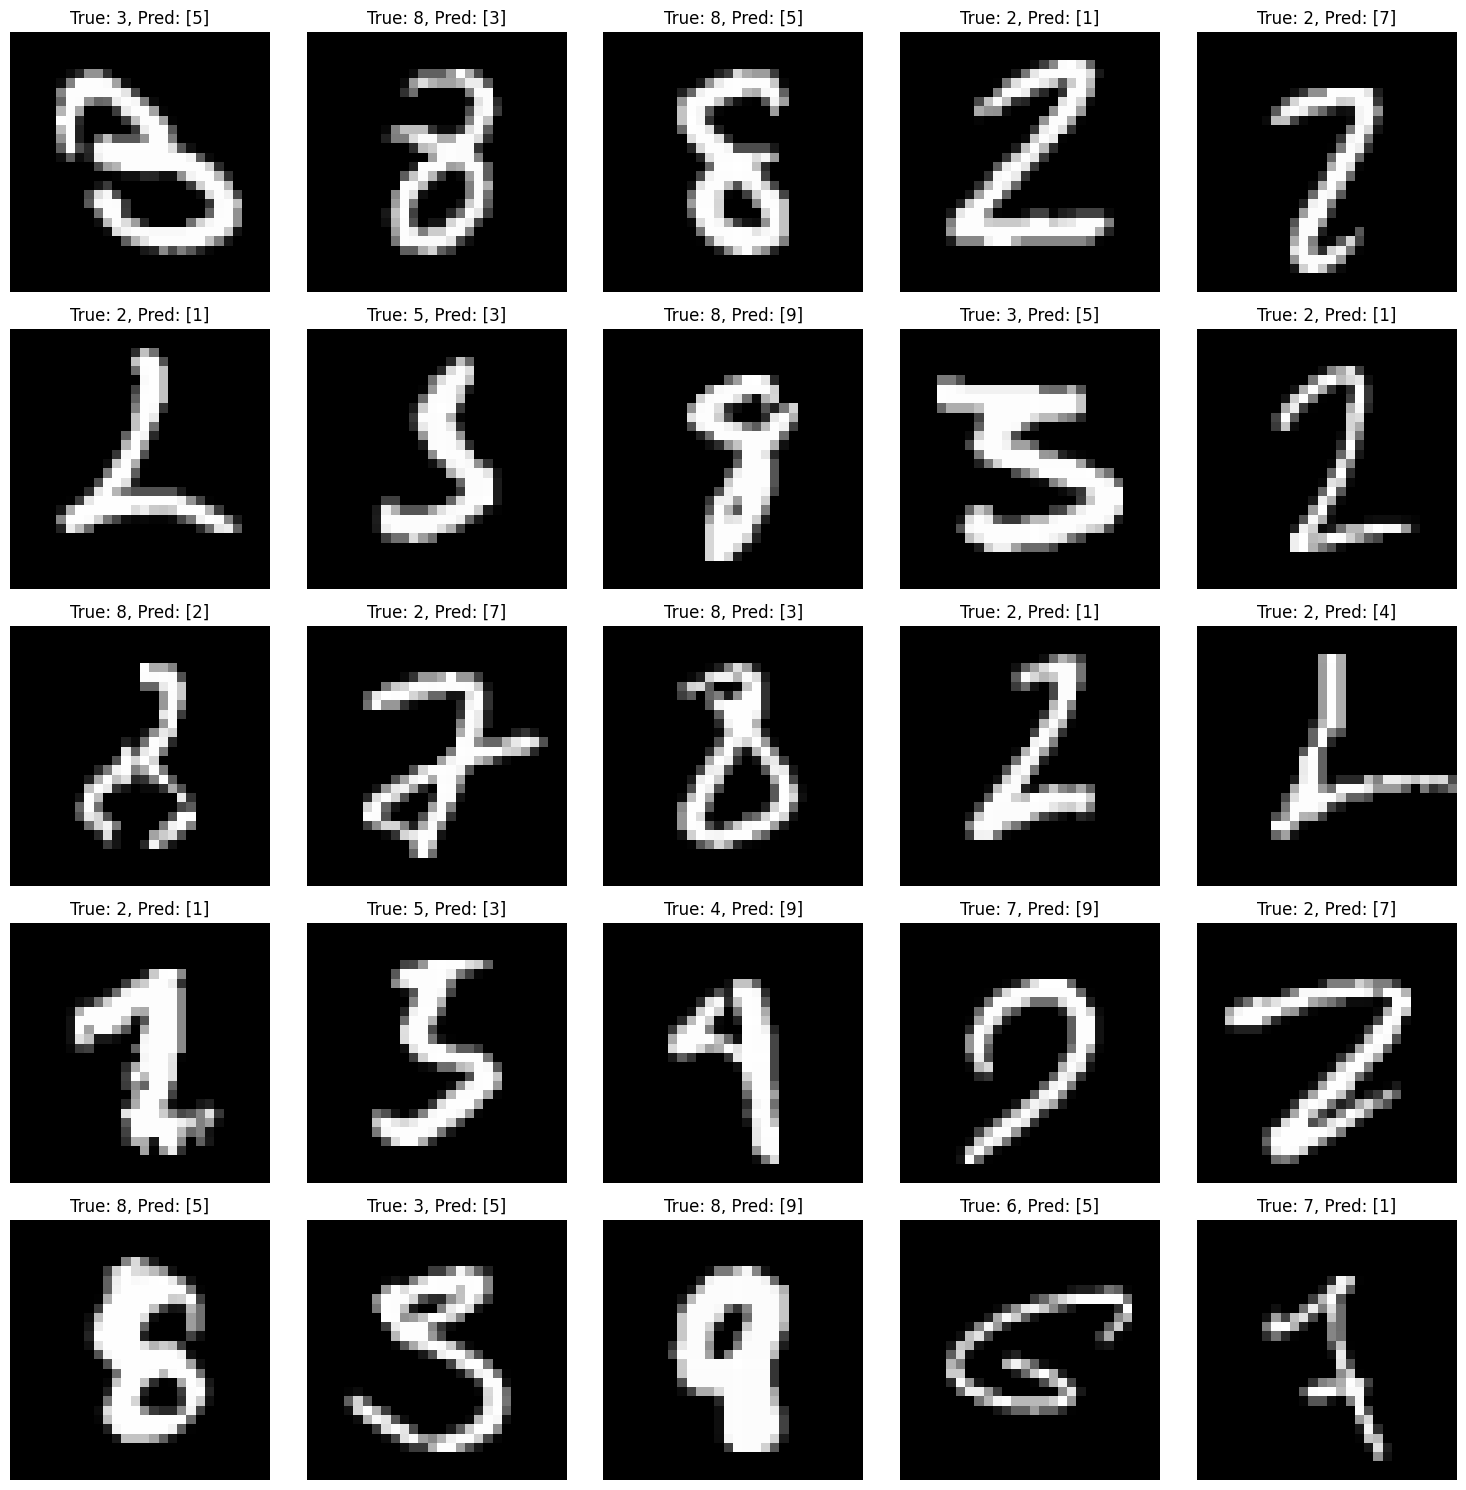

In [16]:
# 3-layer CNN model
model_3_layer = CNN3().to(device)
optimizer_3_layer = optim.RMSprop(model_3_layer.parameters(), lr=0.001)

# Train for 10 epochs
print("Training the 3-layer model...")
for epoch in range(1, 11):
    train(model_3_layer, device, train_loader, optimizer_3_layer, epoch)

# Test and save misclassifications for 3-layer CNN model
print("\nTesting the 3-layer model and displaying misclassifications...")
test_and_save_misclassifications(model_3_layer, device, test_loader, "MNIST_classifications_3_layer.csv", num_misclassified_to_show=25)

Training the 4-layer model...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303015
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.788037
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.570002
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.575171
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.562728
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.540880
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.587877
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.562520
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.522378
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.601340
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.556429
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.522197
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.508101
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.601042
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.584649
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.476374
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.477010
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.468412
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.461471
Train Epoch: 2 [57600/60000 (96%

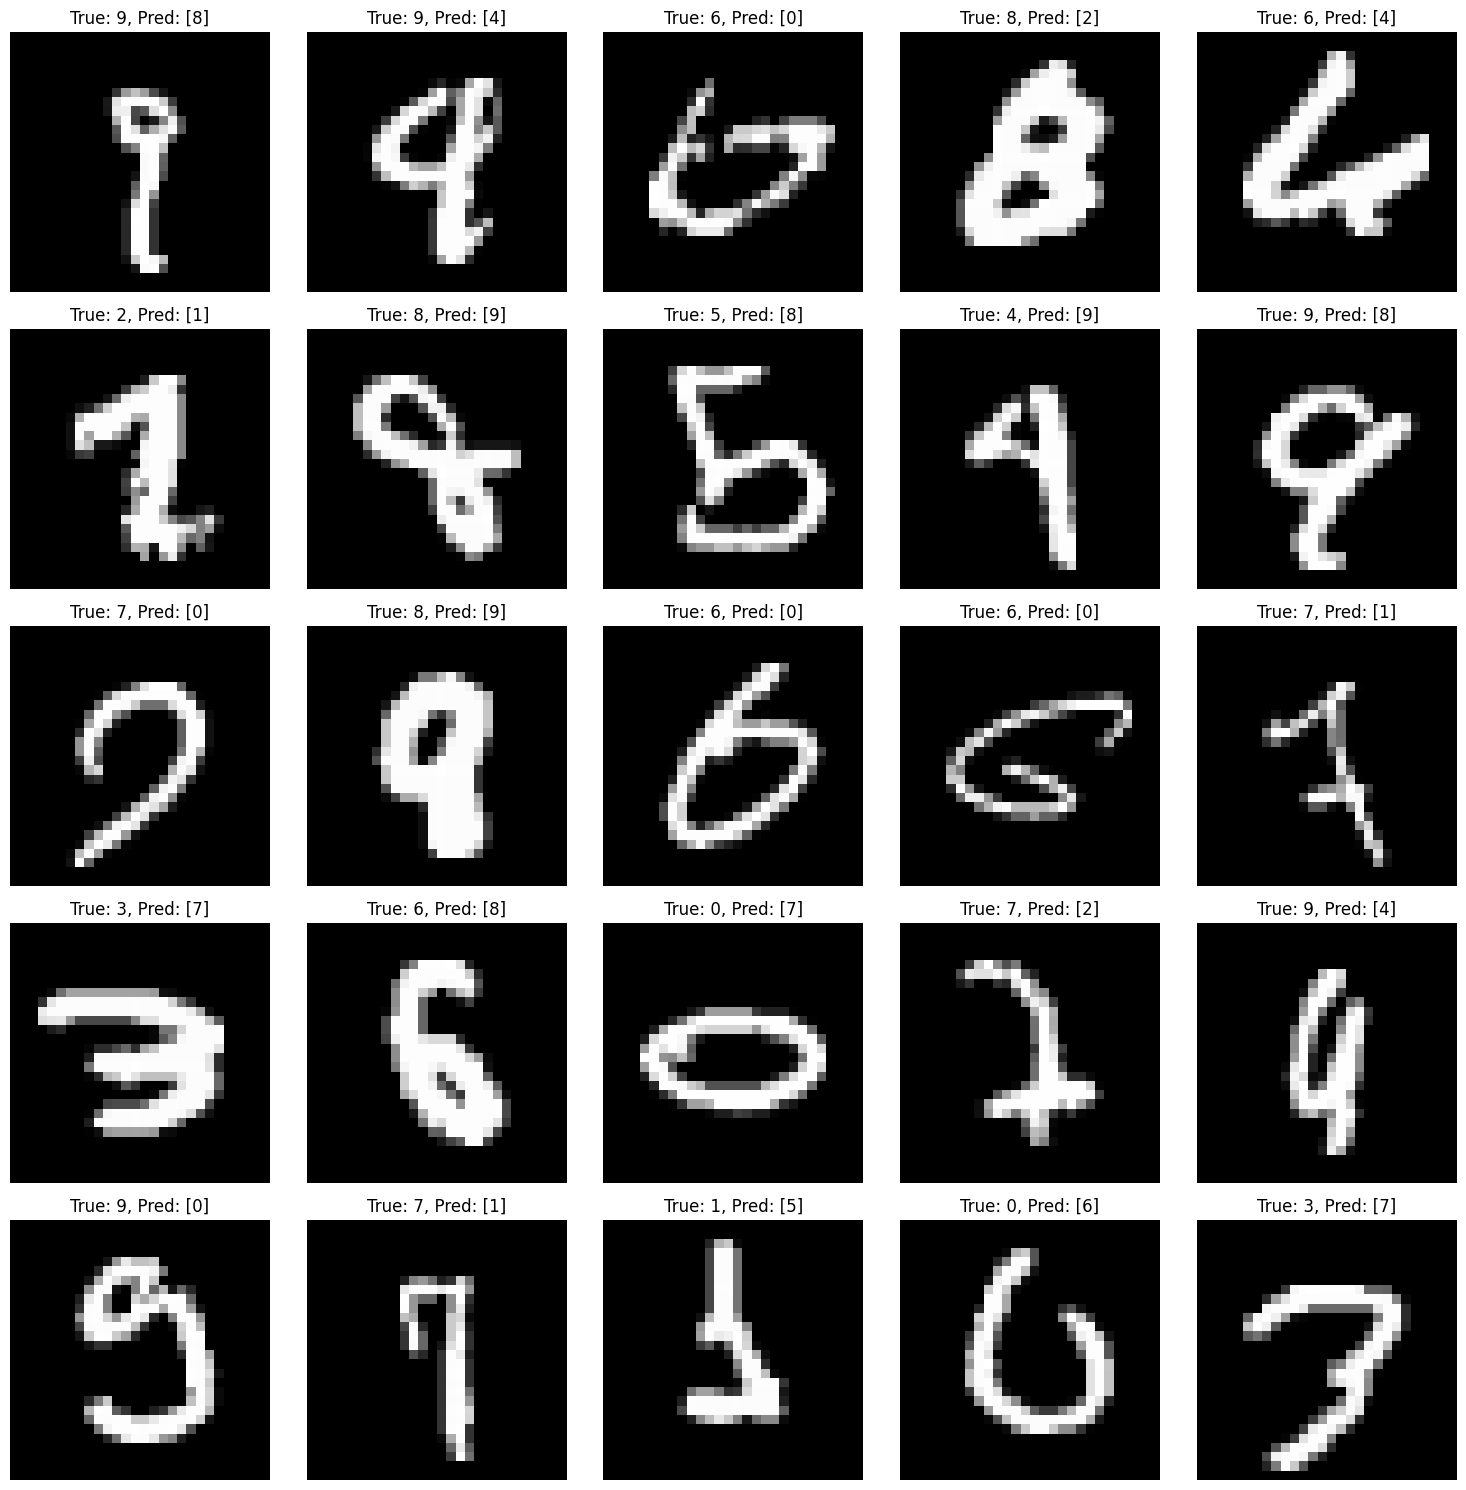

In [17]:
# 4-layer CNN model
model_4_layer = CNN4().to(device)
optimizer_4_layer = optim.RMSprop(model_4_layer.parameters(), lr=0.001)

# Train for 10 epochs
print("Training the 4-layer model...")
for epoch in range(1, 11):
    train(model_4_layer, device, train_loader, optimizer_4_layer, epoch)

# Test and save misclassifications for 4-layer CNN model
print("\nTesting the 4-layer model and displaying misclassifications...")
test_and_save_misclassifications(model_4_layer, device, test_loader, "MNIST_classifications_4_layer.csv", num_misclassified_to_show=25)

In [18]:
# Softmax regression model
def run_softmax_regression(X_train, y_train, X_test, y_test, output_csv):
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Softmax Regression Test Accuracy: {accuracy * 100:.2f}%")
    save_softmax_probabilities(model, X_test, output_csv)

def save_softmax_probabilities(model, X_test, output_csv):
    softmax_probs = model.predict_proba(X_test)
    df = pd.DataFrame(softmax_probs, columns=[f'Class_{i}' for i in range(softmax_probs.shape[1])])
    df['Row_Sum'] = df.sum(axis=1)
    df.to_csv(output_csv, index=False)
    print(f"Softmax probabilities saved to {output_csv}")

# Flatten data for logistic regression
train_images = train_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
test_labels = test_dataset.targets.numpy()

# Run softmax regression
run_softmax_regression(train_images, train_labels, test_images, test_labels, "MNIST_softmax_output.csv")

Softmax Regression Test Accuracy: 92.58%
Softmax probabilities saved to MNIST_softmax_output.csv
